# Predicting Student Success Using Logistic Regression

This notebook explores whether demographic attributes (gender, age, region, disability) can predict whether a student will pass or fail. The data is drawn from the Open University Learning Analytics Dataset (OULAD) and focuses on logistic regression classification using scikit-learn.

---

## Project Objective

To test whether we can predict academic success (pass/fail) using demographic features available at the start of a course — and assess the predictive power of logistic regression models.

---

## Dataset Overview

- **Source**: Public dataset from [OULAD on Kaggle](https://www.kaggle.com/datasets/kukuroo3/open-university-learning-analytics-dataset)
- **Tables used**:
  - `studentInfo`: student demographics and final outcomes
- **Key Features**:
  - `gender`
  - `age_band`
  - `region`
  - `disability`
  - `final_result` (target, filtered to Pass or Fail)

---

## Methodology

1. **Data extraction** from SQLite database
2. **Data cleaning** and encoding of categorical variables
3. **Logistic regression model** using:
   - Basic features (unweighted)
   - Balanced class weights to address target imbalance
4. **Performance evaluation** via:
   - Confusion matrix
   - Classification report (precision, recall, F1)

---

## Key Findings

- Without class balancing, the model predicted “Pass” almost exclusively.
- After applying `class_weight='balanced'`, the model identified:
  - ~56% of failing students (recall)
  - ~64% overall accuracy
- **Demographics alone are weak predictors**, suggesting the need for behavioral/academic data to improve model performance.
  - This helps, though, to support the fairness of academic work across demographics. We can infer that there does not seem to be disparate impact.

---

## Next Steps

- Add behavioral predictors like:
  - Assessment scores
  - VLE interaction time
- Compare logistic regression to:
  - Decision trees
  - Random forests
- Tune thresholds and visualize precision-recall tradeoffs

In [1]:
import sqlite3
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from ipywidgets import interact, Dropdown

In [9]:
sns.set(style="whitegrid", palette="muted", font_scale=1.1)

conn = sqlite3.connect("open_university.db")

In [10]:
modules = pd.read_sql_query("SELECT DISTINCT code_module FROM studentInfo;", conn)
modules_list = sorted(modules['code_module'].tolist())
modules_list

['AAA', 'BBB', 'CCC', 'DDD', 'EEE', 'FFF', 'GGG']

In [ ]:
def plot_module_scores(selected_module):
    query = f"""
    SELECT 
        si.age_band,
        ROUND(AVG(sa.score), 2) AS avg_score
    FROM studentInfo si
    JOIN studentAssessment sa ON si.id_student = sa.id_student
    WHERE si.code_module = '{selected_module}'
    GROUP BY si.age_band
    ORDER BY si.age_band;
    """
    
    df = pd.read_sql_query(query, conn)
    
    plt.figure(figsize=(8, 5))
    sns.barplot(
        data=df,
        x="age_band",
        y="avg_score",
        hue="age_band",         # Assign hue to suppress warning
        palette="crest",
        legend=False            # Hide redundant legend 
             )          
    plt.ylim(0, 100)
    plt.xticks(rotation=0)
    plt.tight_layout()
    plt.show()


In [12]:
interact(plot_module_scores, selected_module=Dropdown(options=modules_list, description="Module:"));

interactive(children=(Dropdown(description='Module:', options=('AAA', 'BBB', 'CCC', 'DDD', 'EEE', 'FFF', 'GGG'…

In [16]:
import statsmodels.api as sm

In [18]:
query = """
SELECT 
    si.gender,
    si.age_band,
    AVG(sa.score) AS avg_score
FROM studentInfo si
JOIN studentAssessment sa ON si.id_student = sa.id_student
WHERE sa.score IS NOT NULL
GROUP BY si.id_student;
"""

df = pd.read_sql_query(query, conn)
conn.close()

In [20]:
# One-hot encode gender and age_band
df_encoded = pd.get_dummies(df, columns=["gender", "age_band"], drop_first=True)

# Features and outcome
X = df_encoded.drop("avg_score", axis=1)
y = df_encoded["avg_score"]
X = sm.add_constant(X)

X = X.astype(float)
y = y.astype(float)

# Fit model
model = sm.OLS(y, X).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:              avg_score   R-squared:                       0.005
Model:                            OLS   Adj. R-squared:                  0.005
Method:                 Least Squares   F-statistic:                     40.28
Date:                Wed, 18 Jun 2025   Prob (F-statistic):           5.91e-26
Time:                        10:26:29   Log-Likelihood:                -97136.
No. Observations:               23351   AIC:                         1.943e+05
Df Residuals:                   23347   BIC:                         1.943e+05
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const             72.3368      0.164    440.

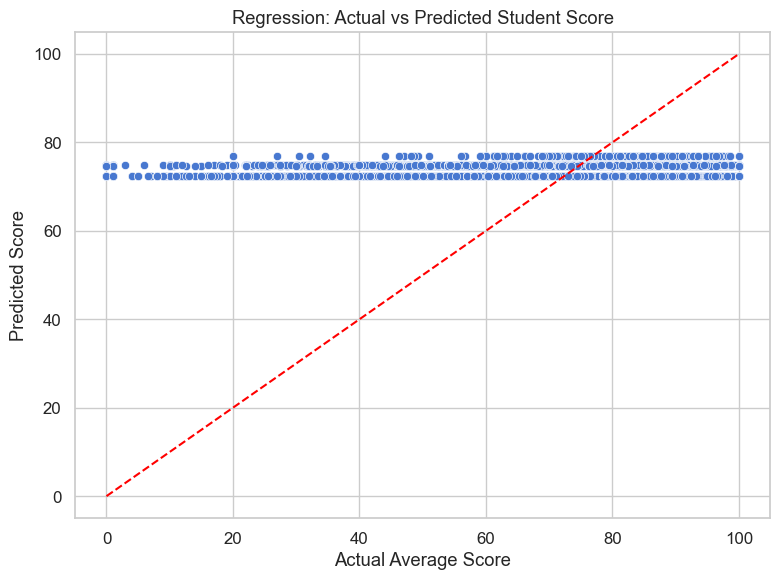

In [21]:
df_encoded["predicted"] = model.predict(X)

plt.figure(figsize=(8, 6))
sns.scatterplot(x=df_encoded["avg_score"], y=df_encoded["predicted"])
plt.plot([df_encoded["avg_score"].min(), df_encoded["avg_score"].max()],
         [df_encoded["avg_score"].min(), df_encoded["avg_score"].max()],
         color="red", linestyle="--")

plt.xlabel("Actual Average Score")
plt.ylabel("Predicted Score")
plt.title("Regression: Actual vs Predicted Student Score")
plt.grid(True)
plt.tight_layout()
plt.show()

In [37]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split

In [38]:
conn = sqlite3.connect("open_university.db")

query = """
SELECT 
    si.gender,
    si.age_band,
    si.region,
    si.disability,
    si.final_result
FROM studentInfo si
WHERE si.final_result IN ('Pass', 'Fail')
"""

df = pd.read_sql_query(query, conn)
conn.close()


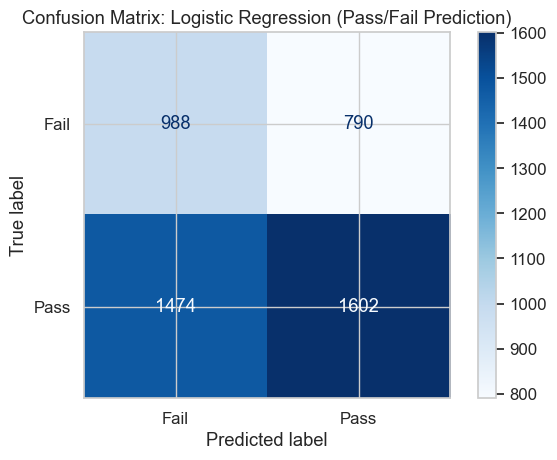

'              precision    recall  f1-score   support\n\n           0       0.40      0.56      0.47      1778\n           1       0.67      0.52      0.59      3076\n\n    accuracy                           0.53      4854\n   macro avg       0.54      0.54      0.53      4854\nweighted avg       0.57      0.53      0.54      4854\n'

In [39]:
df['final_result'] = df['final_result'].map({'Pass': 1, 'Fail': 0})

df_encoded = pd.get_dummies(df, columns=["gender", "age_band", "region", "disability"], drop_first=True)

X = df_encoded.drop("final_result", axis=1)
y = df_encoded["final_result"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

model = LogisticRegression(class_weight='balanced', max_iter=1000)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)



cm = confusion_matrix(y_test, y_pred)
report = classification_report(y_test, y_pred)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Fail", "Pass"])
disp.plot(cmap="Blues")
plt.title("Confusion Matrix: Logistic Regression (Pass/Fail Prediction)")
plt.tight_layout()
plt.show()

report